In [ ]:
pip install pandas

In [ ]:
pip install mysql-connector-python

In [ ]:
pip install matplotlib

In [ ]:
pip install seaborn

In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')
    # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='2206',
    database='ecomerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/vijay/OneDrive/Desktop/Ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(
    host= "localhost" ,
    username = "root" ,
    password = "2206" ,
    database = "ecomerce")

cur = db.cursor()


# List all unique cities where customers are located.  

In [3]:
querry = """select distinct(customer_city) from customers"""
cur.execute(querry)
data = cur.fetchall()
data

[('franca',),
 ('sao bernardo do campo',),
 ('sao paulo',),
 ('mogi das cruzes',),
 ('campinas',),
 ('jaragua do sul',),
 ('timoteo',),
 ('curitiba',),
 ('belo horizonte',),
 ('montes claros',),
 ('rio de janeiro',),
 ('lencois paulista',),
 ('caxias do sul',),
 ('piracicaba',),
 ('guarulhos',),
 ('pacaja',),
 ('florianopolis',),
 ('aparecida de goiania',),
 ('santo andre',),
 ('goiania',),
 ('cachoeiro de itapemirim',),
 ('sao jose dos campos',),
 ('sao roque',),
 ('camacari',),
 ('resende',),
 ('sumare',),
 ('novo hamburgo',),
 ('sao luis',),
 ('sao jose',),
 ('santa barbara',),
 ('ribeirao preto',),
 ('ituiutaba',),
 ('taquarituba',),
 ('sao jose dos pinhais',),
 ('barrinha',),
 ('parati',),
 ('dourados',),
 ('trindade',),
 ('cascavel',),
 ('fortaleza',),
 ('brasilia',),
 ('pelotas',),
 ('porto alegre',),
 ('salto',),
 ('jundiai',),
 ('cacapava',),
 ('sao vicente',),
 ('uberlandia',),
 ('botelhos',),
 ('sao goncalo',),
 ('araucaria',),
 ('nova iguacu',),
 ('areia branca',),
 ('campo

# Count the number of orders placed in 2017.

In [7]:
query = """
SELECT COUNT(order_id)
FROM orders
where  YEAR(order_purchase_timestamp) = 2017
GROUP BY YEAR(order_purchase_timestamp)
"""
cur.execute(query)
data = cur.fetchall()
"Number of order placed in 2017 are ", data[0] [0]




('Number of order placed in 2017 are ', 45101)

 # Find the total sales per category. 

In [16]:
query = """ select pr.product_category category , round(sum(pm.payment_value),2) sales
from products pr join order_items oi
on pr.product_id = oi.product_id join payments pm
on pm.order_id = oi.order_id
group by category 
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Category', 'Sales'])
df

,Category,Sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


#  Calculate the percentage of orders that were paid in installments.

In [27]:
query = """ select  sum(case when payment_installments >= 1 then 1 else 0 end)/ count(order_id) * 100 as insta_orders_percentage
 -- case when payment_installments = 1 then 1  else 0 end as non_insts_orders
from payments
"""
cur.execute(query)
data = cur.fetchall()
"the percentage of orders that were placed in installments is ", data[0][0]

('the percentage of orders that were placed in installments is ',
 Decimal('99.9981'))

# Count the number of customers from each state. 

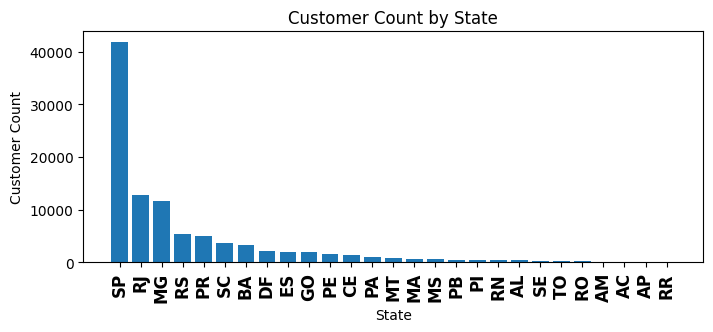

In [81]:
query = """ select customer_state , count(customer_id) customers
from customers 
group by customer_state
order by customers desc
"""
cur.execute(query)
data = cur.fetchall()
"the number of customers from each state is ", data
df = pd.DataFrame(data, columns = ['State', 'Customer_count'])
plt.figure(figsize= (8,3))
plt.bar(df['State'], df['Customer_count'])
plt.xticks(rotation = 90,fontsize=12, color='black', fontweight='bold')  # it rotates the labels on the x-axis by 90 degrees, making them vertical.
plt.xlabel('State')
plt.ylabel('Customer Count')
plt.title('Customer Count by State')
plt.show()


# Calculate the number of orders per month in 2018.

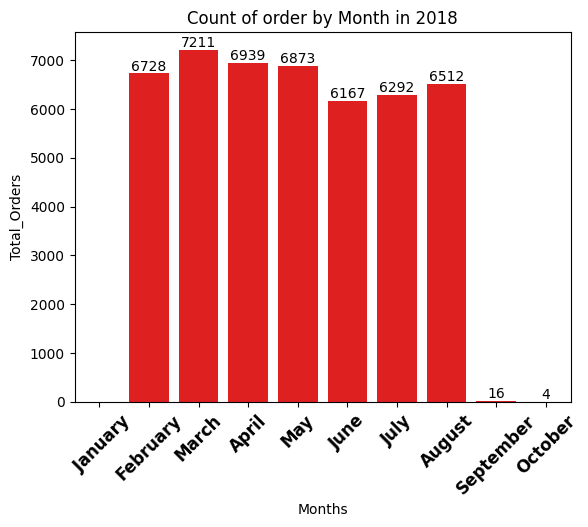

In [100]:
query = """ select monthname(order_purchase_timestamp) month2018 , count(order_id) total_orders
from orders 
where year(order_purchase_timestamp) = 2018
group by month2018
order by total_orders desc
"""
cur.execute(query)
data = cur.fetchall()
#"The number of orders per month in 2018 is ", data
df = pd.DataFrame(data, columns = ['Months', 'Total_Orders'])
# plt.figure(figsize= (8,3))
#plt.bar(df['Months'], df['Total_Orders'])
#plt.xlabel('Month')
#plt.ylabel('Total Orders')
O = [" January" , "February" , "March" ,"April" ,"May" , "June" ,"July" , "August", "September" , "October"]
ax =sns.barplot( x = df["Months"], y = df["Total_Orders"], data = df, order = O, color = "red")
plt.xticks(rotation = 45,fontsize=12, color='black', fontweight='bold')  # it rotates the labels on the x-axis by 90 degrees, making them vertical.
ax.bar_label(ax.containers[0])
plt.title('Count of order by Month in 2018')
plt.show()

# Find the average number of products per order, grouped by customer city.

In [108]:
query = """ with t1 as 
(select o.order_id ,o.customer_id , count(oi.order_id) orders
from orders o join order_items oi
on o.order_id = oi.order_id
group by 1,2)

select c.customer_city , round(avg(t1.orders),2) avg_orders
from customers c
join t1 on t1.customer_id = c.customer_id
group by 1
order by 2 desc
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Customer City', 'Avg Products per Orders'])
df.head(10)

,Customer City,Avg Products per Orders
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# Calculate the percentage of total revenue contributed by each product category

               Category  Revenue Percentage
0        BED TABLE BATH               10.70
1         HEALTH BEAUTY               10.35
2  COMPUTER ACCESSORIES                9.90
3  FURNITURE DECORATION                8.93
4       WATCHES PRESENT                8.93
5         SPORT LEISURE                8.70
6            HOUSEWARES                6.84
7            AUTOMOTIVE                5.32
8          GARDEN TOOLS                5.24
9            COOL STUFF                4.87


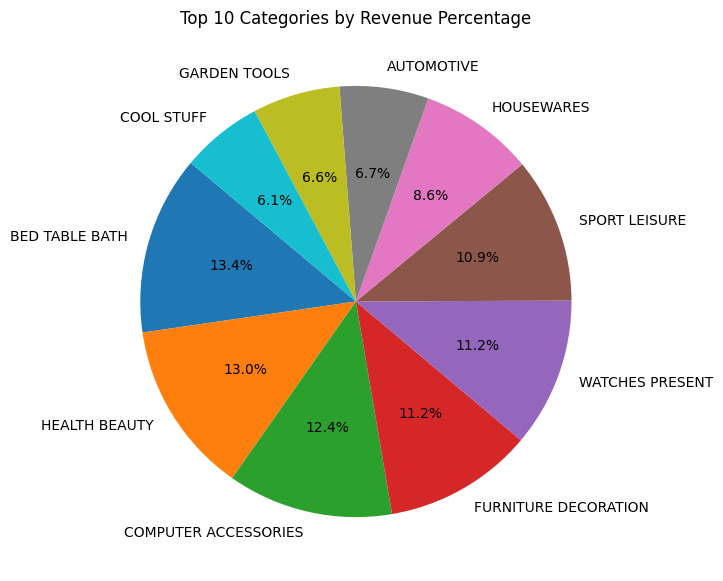

In [127]:
query = """ select upper(pr.product_category) category ,
round(sum(pm.payment_value)/(select sum(payment_value) from payments) * 100,2) revenue_percentage
from products pr join order_items oi
on pr.product_id = oi.product_id join payments pm
on pm.order_id = oi.order_id
group by category
order by 2 desc

"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Category', 'Revenue Percentage'])
#df.head(10)
df_sorted = df.sort_values(by='Revenue Percentage', ascending=False)

# Select the top 10 categories
df_top10 = df_sorted.head(10)

# Display the top 10 categories
print(df_top10)
# Plot the pie chart
plt.figure(figsize=(10, 7))
plt.pie(df_top10['Revenue Percentage'], labels=df_top10['Category'], autopct='%1.1f%%', startangle=140)

# Add a title
plt.title('Top 10 Categories by Revenue Percentage')

# Display the plot
plt.show()

# Identify the correlation between product price and the number of times a product has been purchased.

In [139]:
import numpy as np
query = """ select p.product_category, count(oi.product_id), round(avg(oi.price),2)
from products p join order_items oi on
oi.product_id = p.product_id
group by 1

"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Category", "Order count" ,"Price"])

arr1 = df["Order count"]
arr2 = df["Price"]
a = np.corrcoef([arr1 , arr2])
print(" the correlation between product price and the number of times a product has been purchased is " , a[0][1])

 the correlation between product price and the number of times a product has been purchased is  -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue.

In [142]:
query = """ select * , rank() over (order by revenue desc) as rn from 
(select oi.seller_id , sum(p.payment_value) revenue
from order_items oi join payments p on
oi.order_id = p.order_id
group by 1) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Seller ID", "Revenue" ,"Rank"])

df.head(5)

,Seller ID,Revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.907302,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.039840,2
2,4a3ca9315b744ce9f8e9374361493884,301245.269765,3
3,1f50f920176fa81dab994f9023523100,290253.420128,4
4,53243585a1d6dc2643021fd1853d8905,284903.080498,5


# Calculate the moving average of order values for each customer over their order history.

In [144]:
query = """with t1 as (select o.customer_id , o.order_purchase_timestamp , p.payment_value
from orders o join payments p on
o.order_id = p.order_id) 

select customer_id , order_purchase_timestamp ,payment_value , avg(payment_value)
over (partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from t1 """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Customer ID", "Time", "Payment", "Moving Average"])

df

,Customer ID,Time,Payment,Moving Average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


 # Calculate the cumulative sales per month for each year.

In [152]:
query = """with t1 as (select year(o.order_purchase_timestamp) years, month(o.order_purchase_timestamp) months, round(sum(p.payment_value),2) Sales
from orders o join payments p on
o.order_id = p.order_id
group by 1, 2
order by 1,2)

select years, months , sales ,
-- cum sales year wise:
sum(sales) over (partition by years order by months) as cum_sales_year ,
-- total cum sales:
sum(sales) over (order by years, months) as Total_cum_sales
from t1 """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Years", "Month", "Sales", "Cum sales For each year","Total_Cum_sales"])

df

,Years,Month,Sales,Cum sales For each year,Total_Cum_sales
0,2016,9,252.24,252.24,252.24
1,2016,10,59090.48,59342.72,59342.72
2,2016,12,19.62,59362.34,59362.34
3,2017,1,138488.04,138488.04,197850.38
4,2017,2,291908.01,430396.05,489758.39
5,2017,3,449863.60,880259.65,939621.99
6,2017,4,417788.03,1298047.68,1357410.02
7,2017,5,592918.82,1890966.50,1950328.84
8,2017,6,511276.38,2402242.88,2461605.22
9,2017,7,592382.92,2994625.80,3053988.14


# Calculate the year-over-year growth rate of total sales.

In [153]:
query = """with t1 as(select year(o.order_purchase_timestamp) years, round(sum(p.payment_value),2) Sales
from orders o join payments p on
o.order_id = p.order_id
group by 1
order by 1)

select years, sales, lag(sales, 1) over(order by years) previous_year , (sales - lag(sales, 1) over(order by years)) growth ,
((sales - lag(sales, 1) over(order by years)) / lag(sales, 1) over(order by years)) * 100 yoy_per_growth 
from t1"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Years", "Sales", "Prev Year Sale", "Growth","Percentage Growth"])

df

,Years,Sales,Prev Year Sale,Growth,Percentage Growth
0,2016,59362.34,NaN,NaN,NaN
1,2017,7249746.73,59362.34,7190384.39,12112.703761
2,2018,8699763.05,7249746.73,1450016.32,20.000924


#  Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [157]:
query = """with a as (select c.customer_id customer, min(o.order_purchase_timestamp) first_order
from customers c join orders o on
c.customer_id = o.customer_id
group by 1 ),

b as (select a.customer, count(distinct o.order_purchase_timestamp)
from a join orders o on
o.customer_id = a.customer
where o.order_purchase_timestamp > a.first_order and o.order_purchase_timestamp <
date_add(first_order, interval 6 month)
group by 1)

select 100 * (count(distinct a.customer ) / count(distinct b.customer ))
from a left join b
on a.customer = b.customer """

cur.execute(query)
data = cur.fetchall()
print('None of the customer has repeated the order in past 6 month, hence the result is showing none')
data


None of the customer has repeated the order in past 6 month, hence the result is showing none


[(None,)]

 # Identify the top 3 customers who spent the most money in each year

<function matplotlib.pyplot.show(close=None, block=None)>

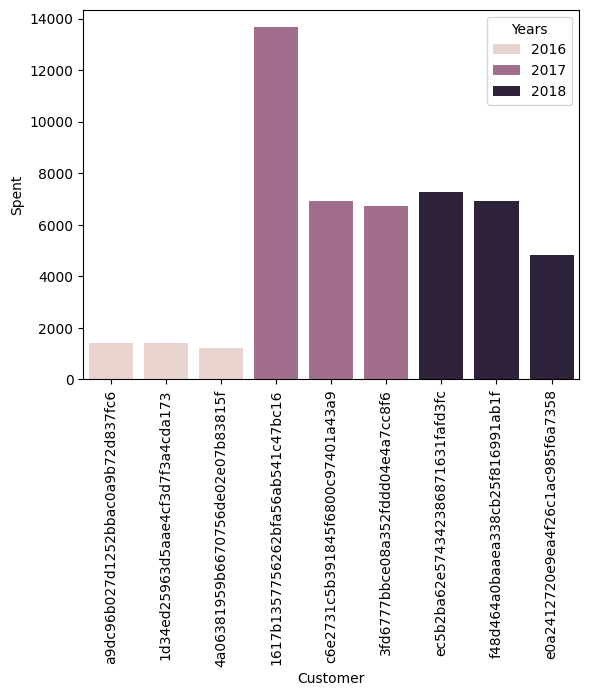

In [161]:
 query = """with t1 as (select o.Customer_id, year(o.order_purchase_timestamp) years ,sum(p.payment_value) spent,
rank() over ( partition by year(o.order_purchase_timestamp) order by sum(p.payment_value) desc) rnk
from orders o
join payments p on
o.order_id = p.order_id
group by 1,2)

select customer_id , years , spent , rnk
from t1
where rnk <= 3 """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Customer", "Years", "Spent", "Rank"])
sns.barplot(x = "Customer" , y = "Spent", data = df, hue = "Years")
plt.xticks(rotation = 90)
plt.show
            